In [161]:
import torch
import torchtext

import pandas as pd
#pd.options.display.max_colwidth = 300
import os
import matplotlib.pyplot as plt
import seaborn as sns
# change fonts to serif
plt.rcParams['font.family'] = 'serif'
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from math import comb
from statsmodels.formula.api import ols
import statsmodels.api as sm
from functools import reduce

In [162]:
# trained on Wikipedia 2014 + Gigaword 5 vectors
glove = torchtext.vocab.GloVe(name="6B", dim=50, cache='.vector_cache')  

def avg_euclidean_dist(w_lst):
    '''
    Takes in a list of word, computes the sum of euclidean disctance of each
    word-word pair
    '''
    
    eu_dist = torch.tensor(0.0)     # initiates the euclidean distance

    for idx, word_x in enumerate(w_lst):
        if idx != len(w_lst) - 1:       # if not the last word        
            x = glove[word_x]
            for word_y in w_lst[idx+1:]:
                y = glove[word_y]
                eu_dist += torch.norm(y-x)

    C = comb(len(w_lst), 2)
    # divided by the number of possible combinations
    avg_dist = eu_dist/C

    return avg_dist


def avg_cosine_sim(w_lst):
    '''
    Takes in a list of word, computes the sum of euclidean disctance of each
    word-word pair
    '''
    
    cosine_sim = torch.tensor([0.0])     # initiates cosine similarity value

    for idx, word_x in enumerate(w_lst):
        if idx != len(w_lst) - 1:       # if not the last word        
            x = glove[word_x]
            for word_y in w_lst[idx+1:]:
                y = glove[word_y]
                cosine_sim += torch.cosine_similarity(x.unsqueeze(0), y.unsqueeze(0))
    
    C = comb(len(w_lst), 2)
    # divided by the number of possible combinations
    avg_cosine = cosine_sim/C

    return avg_cosine

In [163]:
subfields = ['atomicphysics', 'biophysics', 'geophysics', 'meteorology', 
             'oceanography', 'statistics', 'thermodynamics']

Looks at how similar top 25% of stemmed tokens are within a year

In [61]:
def get_df(subfield_name):
    '''
    takes in a string of subfield name, outputs a dataframe
    from 2000-2020
    '''

    file_path = os.getcwd() + '/data/'+subfield_name+'_df.csv'
    df = pd.read_csv(file_path, index_col=0)

    # get the section we want to analyze
    df = df.iloc[-(df.iloc[-1, 0]-2000+1):-(df.iloc[-1, 0]-2020), [0, -2, -1]].reset_index(drop=True) 

    # set name
    df.name = subfield_name
    return df

In [164]:
def minmax_scale(df, col_name):
    '''
    MinMax normalize the data to [0, 1]
    '''

    df[col_name] = df[col_name].apply(lambda x: (x-df[col_name].min())/(df[col_name].max()-df[col_name].min()))
    
    return df

In [168]:
# get all dfs
atomic_df = get_df(subfields[0])
bio_df = get_df(subfields[1])
geo_df = get_df(subfields[2])
meteo_df = get_df(subfields[3])
ocean_df = get_df(subfields[4])
stats_df = get_df(subfields[5])
thermo_df = get_df(subfields[6])

In [169]:
# validate that we get dfs of the same shape
atomic_df.shape == bio_df.shape == geo_df.shape == meteo_df.shape 
meteo_df.shape == ocean_df.shape == stats_df.shape == thermo_df.shape

True

In [177]:
def ols_summary_plot(y, x, df):
    '''
    Analyzes the shift of musics features from 1950 to 2015
    Inputs:
        y: string, the name of dependent variable
        x: string, the name of independent variable
        df: pandas dataframe, data source of the analysis
    Outputs:
        OLS Regression Results and a scatter plot with a linear regression line
    '''

    mod = ols(formula='{} ~ {}'.format(y, x), data=df).fit()
    print(mod.summary())
    ax = df.plot(x=x, y=y, kind='scatter',
                title=f'Shift of {y} Over Publication Years', grid=True)
    plt.xlabel('Publication Year')
    plt.xticks(np.arange(2000, 2021, 2), rotation=45)
    fig = sm.graphics.abline_plot(model_results=mod, ax=ax)

In [178]:
def process_df(df):
    '''
    Process the dataframes, calculate the average euclidean distance
    and cosine similarity, and fit the OLS model
    '''

    df['tokens'] = df["t25% of stemmed_tokens"].apply(lambda x: eval(x)[0])\
                                               .apply(lambda x: [i[0] for i in x])
    df['avg_euclidean_dist'] = df['tokens'].apply(avg_euclidean_dist).apply(lambda x: x.item())
    df['avg_cosine_sim'] = df['tokens'].apply(avg_cosine_sim).apply(lambda x: x.item())

    # minmax scale the data to 0 to 1
    df = minmax_scale(df, 'avg_euclidean_dist')
    df = minmax_scale(df, 'avg_cosine_sim')

    # save to local
    df.to_csv(f'data/glove_{df.name}.csv')

    # fit ols
    ols_summary_plot(y='avg_euclidean_dist', x='publication_year', df=df)
    ols_summary_plot(y='avg_cosine_sim', x='publication_year', df=df)
    
    return df

                            OLS Regression Results                            
Dep. Variable:     avg_euclidean_dist   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.251
Date:                Wed, 08 Mar 2023   Prob (F-statistic):              0.277
Time:                        11:48:13   Log-Likelihood:               0.021136
No. Observations:                  21   AIC:                             3.958
Df Residuals:                      19   BIC:                             6.047
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           21.1625     18.408  

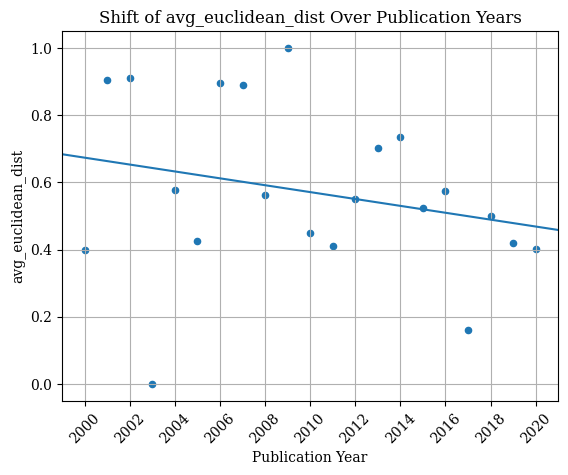

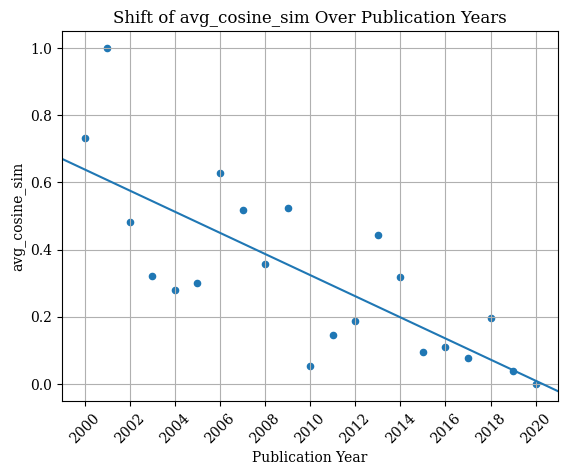

In [179]:
# cosine similarity is significant
atomic_df = process_df(atomic_df)

                            OLS Regression Results                            
Dep. Variable:     avg_euclidean_dist   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     154.8
Date:                Wed, 08 Mar 2023   Prob (F-statistic):           1.41e-10
Time:                        11:34:24   Log-Likelihood:                 14.423
No. Observations:                  21   AIC:                            -24.85
Df Residuals:                      19   BIC:                            -22.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          115.8521      9.272  

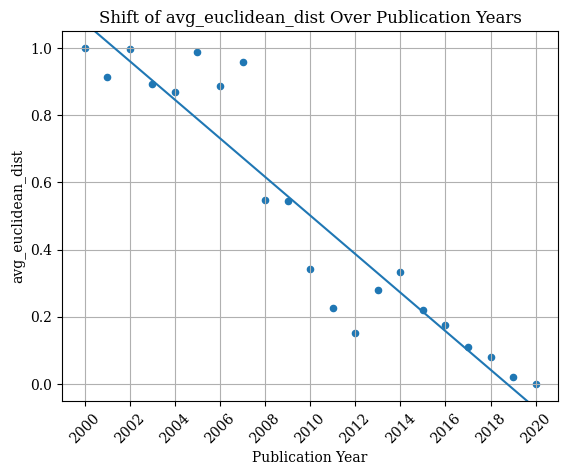

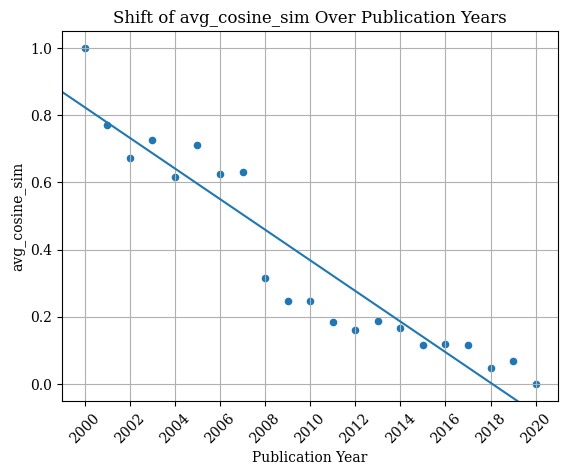

In [170]:
# both significant
bio_df = process_df(bio_df)

                            OLS Regression Results                            
Dep. Variable:     avg_euclidean_dist   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.076
Date:                Wed, 08 Mar 2023   Prob (F-statistic):              0.313
Time:                        11:48:41   Log-Likelihood:                 3.0649
No. Observations:                  21   AIC:                            -2.130
Df Residuals:                      19   BIC:                          -0.04084
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -15.9800     15.924  

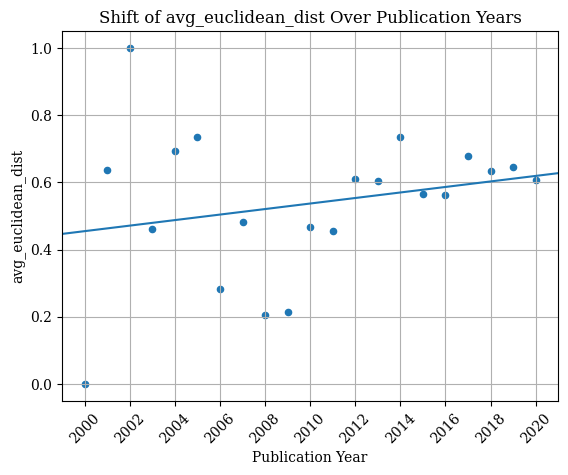

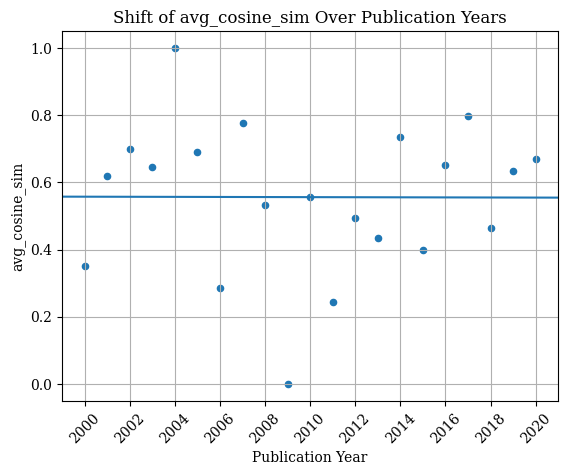

In [180]:
# both not significant
geo_df = process_df(geo_df)

                            OLS Regression Results                            
Dep. Variable:     avg_euclidean_dist   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.052
Method:                 Least Squares   F-statistic:                  0.003266
Date:                Wed, 08 Mar 2023   Prob (F-statistic):              0.955
Time:                        11:50:18   Log-Likelihood:                -2.3915
No. Observations:                  21   AIC:                             8.783
Df Residuals:                      19   BIC:                             10.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.7284     20.649  

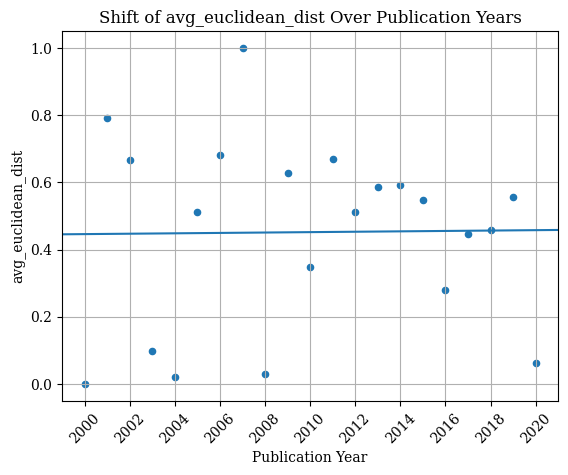

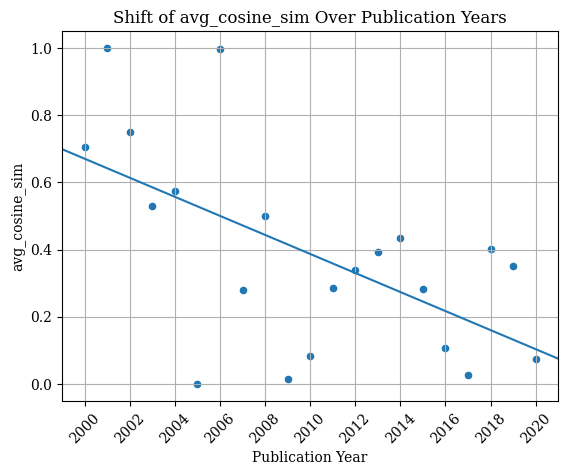

In [181]:
# cosine similarity significant
meteo_df = process_df(meteo_df)

                            OLS Regression Results                            
Dep. Variable:     avg_euclidean_dist   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     41.78
Date:                Wed, 08 Mar 2023   Prob (F-statistic):           3.40e-06
Time:                        11:55:06   Log-Likelihood:                 7.6272
No. Observations:                  21   AIC:                            -11.25
Df Residuals:                      19   BIC:                            -9.165
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           83.3225     12.815  

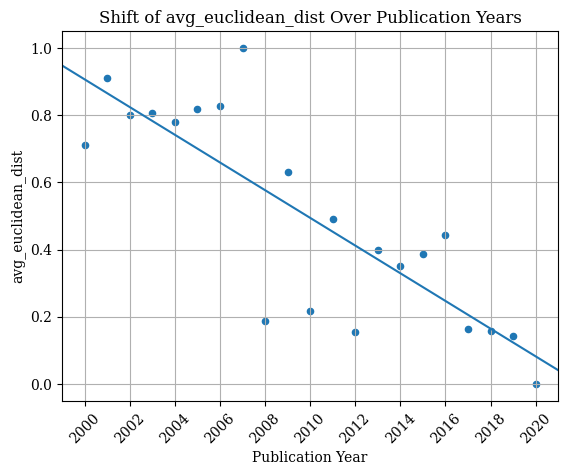

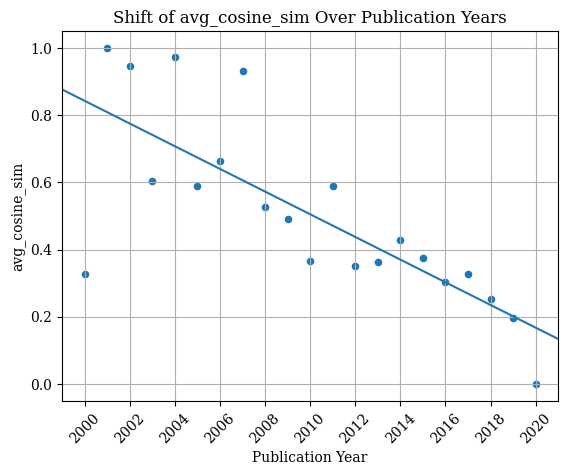

In [182]:
# both significant
ocean_df = process_df(ocean_df)

                            OLS Regression Results                            
Dep. Variable:     avg_euclidean_dist   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     4.745
Date:                Wed, 08 Mar 2023   Prob (F-statistic):             0.0422
Time:                        12:02:28   Log-Likelihood:               -0.13461
No. Observations:                  21   AIC:                             4.269
Df Residuals:                      19   BIC:                             6.358
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -39.8473     18.545  

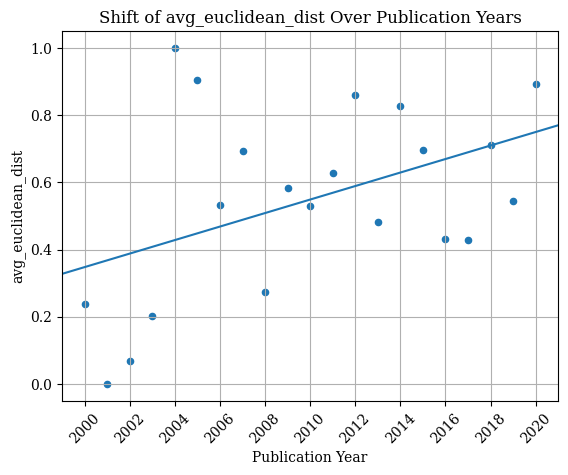

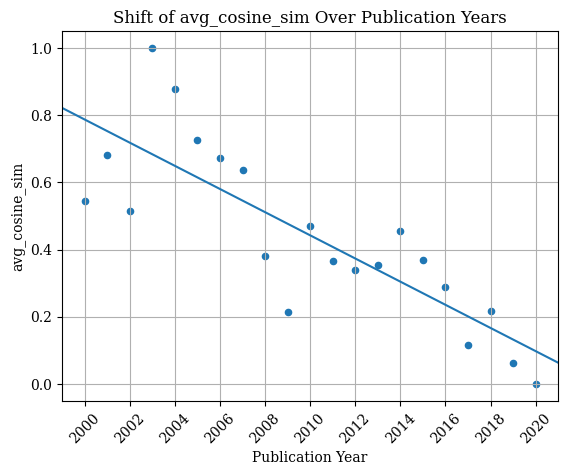

In [183]:
# cosine similarity
stats_df = process_df(stats_df)

                            OLS Regression Results                            
Dep. Variable:     avg_euclidean_dist   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     14.13
Date:                Wed, 08 Mar 2023   Prob (F-statistic):            0.00133
Time:                        12:05:02   Log-Likelihood:                 4.7653
No. Observations:                  21   AIC:                            -5.531
Df Residuals:                      19   BIC:                            -3.441
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           55.6455     14.686  

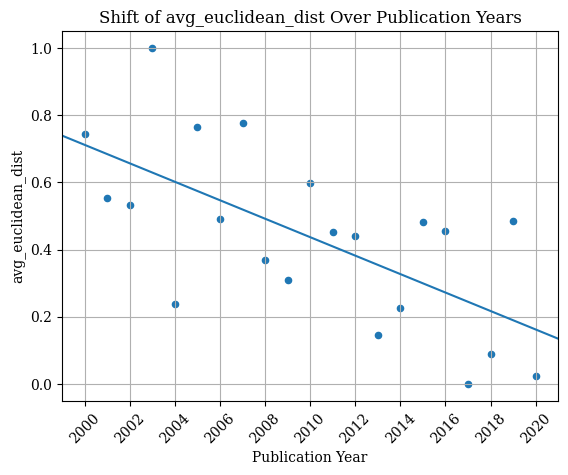

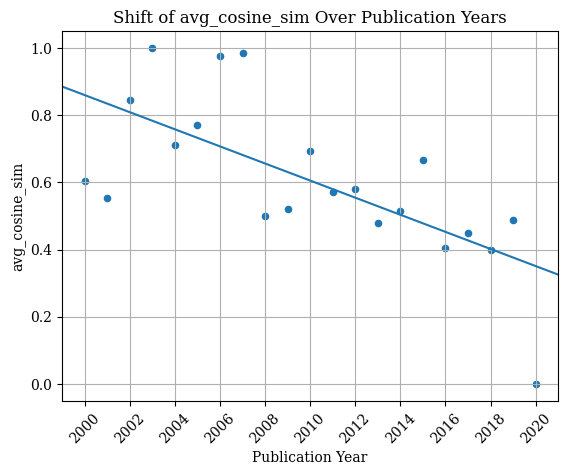

In [184]:
# both significant
thermo_df = process_df(thermo_df)

### Merge Cosine Similarity Results

In [185]:
def select_cosine_sim(df):
    df_ = df.iloc[:, [0, -1]]
    df_ = df_.rename(columns={'avg_cosine_sim': df.name})

    return df_ 

In [193]:
atomic_cosim = select_cosine_sim(atomic_df)
bio_cosim = select_cosine_sim(bio_df)
geo_cosim = select_cosine_sim(geo_df)
meteo_cosim = select_cosine_sim(meteo_df)
ocean_cosim = select_cosine_sim(ocean_df)
stats_cosim = select_cosine_sim(stats_df)
thermo_cosim = select_cosine_sim(thermo_df)

In [194]:
cosim_df_lst = [atomic_cosim, bio_cosim, geo_cosim, meteo_cosim, ocean_cosim, stats_cosim, thermo_cosim]

In [195]:
cosim_df = reduce(lambda left,right: pd.merge(left,right,on=['publication_year'],
                                            how='outer'), cosim_df_lst)

In [196]:
# save a copy
cosim_df.to_csv('data/cosim_results.csv')

In [197]:
cosim_df.head()

,publication_year,atomicphysics,biophysics,geophysics,meteorology,oceanography,statistics,thermodynamics
0,2000,0.732243,1.000000,0.349547,0.706141,0.328611,0.543160,0.604860
1,2001,1.000000,0.769718,0.619571,1.000000,1.000000,0.681476,0.551929
2,2002,0.480828,0.673252,0.699335,0.749886,0.945302,0.514263,0.844752
3,2003,0.321675,0.725995,0.644180,0.528878,0.603478,1.000000,1.000000
4,2004,0.280863,0.616989,1.000000,0.573527,0.973308,0.878358,0.712034


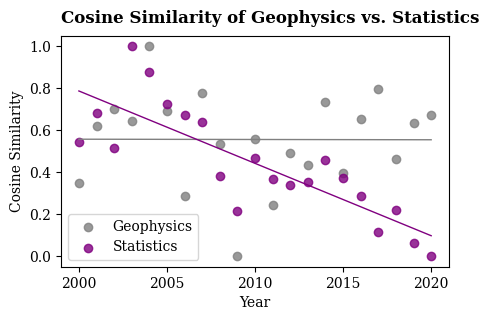

In [159]:
# specify dimensions of plot
width = 5
height = 3

# plot arrays
fig, ax = plt.subplots(figsize = [width, height], dpi = 100, 
                       facecolor = "white", edgecolor = "white")

sns.regplot(data=cosim_df, x='publication_year', y='geophysics', fit_reg=True, 
            ci=None, ax=ax, scatter_kws={'color': 'grey'},
            line_kws={'color': 'grey', 'linewidth':1}, label='Geophysics')
sns.regplot(data=cosim_df, x='publication_year', y='statistics', fit_reg=True, 
            ci=None, ax=ax, scatter_kws={'color': 'purple'},
            line_kws={'color': 'purple', 'linewidth':1}, label='Statistics')

ax.set_xticks(np.arange(2000, 2021, 5))

# set title and axis titles
ax.set_xlabel('Year', size = 10, **{'fontname':'serif'})
ax.set_ylabel('Cosine Similarity', size = 10, **{'fontname':'serif'})
ax.set_title('Cosine Similarity of Geophysics vs. Statistics', 
             fontweight='bold', size = 12, loc='left', y=1.02)

# add legend
ax.legend()

In [160]:
# save plot as png and pdf (keep dpi at 800 or higher for good resolution)
fig.savefig('glove.pdf', bbox_inches='tight', dpi=800)
fig.savefig('glove.png', bbox_inches='tight', dpi=800)

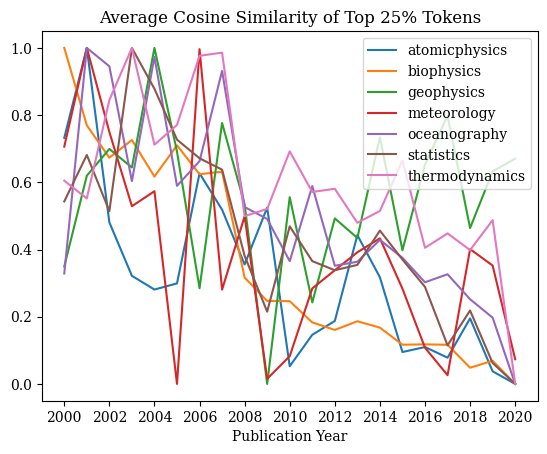

In [199]:
# line plot
cosim_df.plot(x='publication_year', y=cosim_df.columns[1:].to_list(), 
              title='Average Cosine Similarity of Top 25% Tokens',
              xlabel='Publication Year')
plt.xticks(np.arange(2000, 2021, 2));

                            OLS Regression Results                            
Dep. Variable:          atomicphysics   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     25.75
Date:                Wed, 08 Mar 2023   Prob (F-statistic):           6.73e-05
Time:                        12:12:20   Log-Likelihood:                 8.2328
No. Observations:                  21   AIC:                            -12.47
Df Residuals:                      19   BIC:                            -10.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           63.5030     12.451  

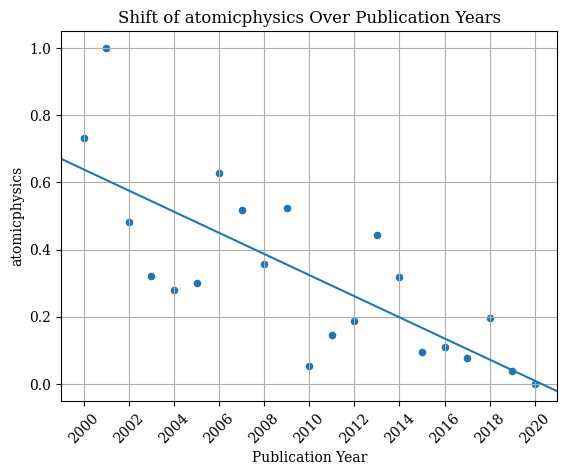

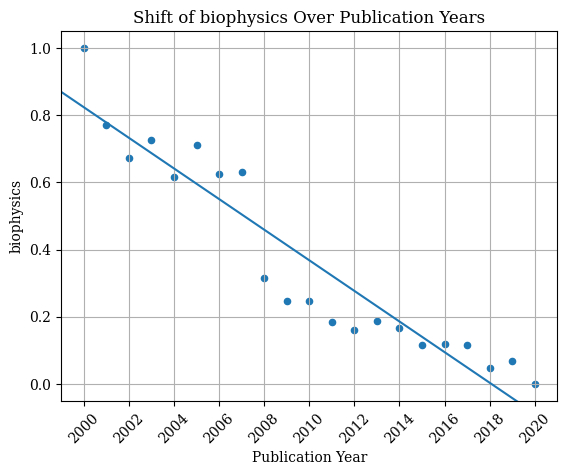

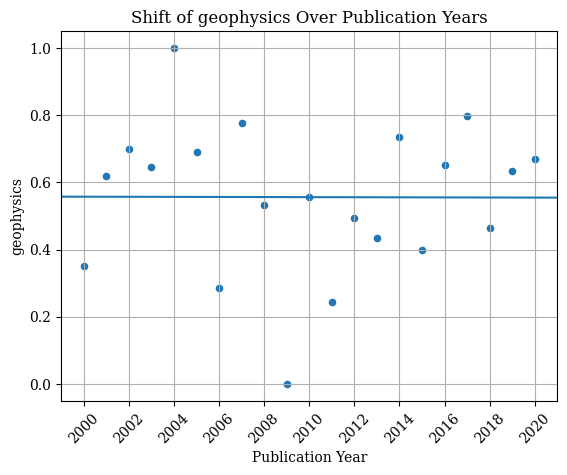

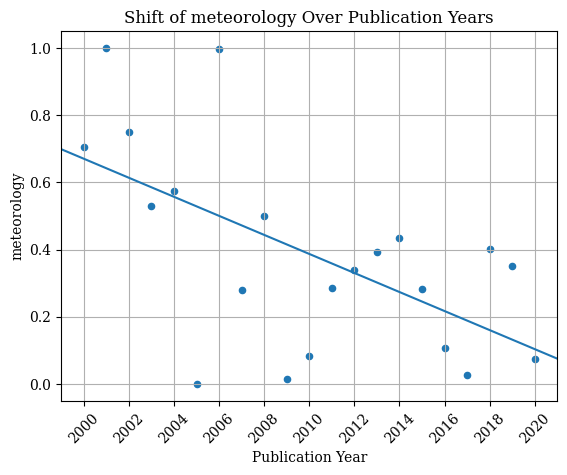

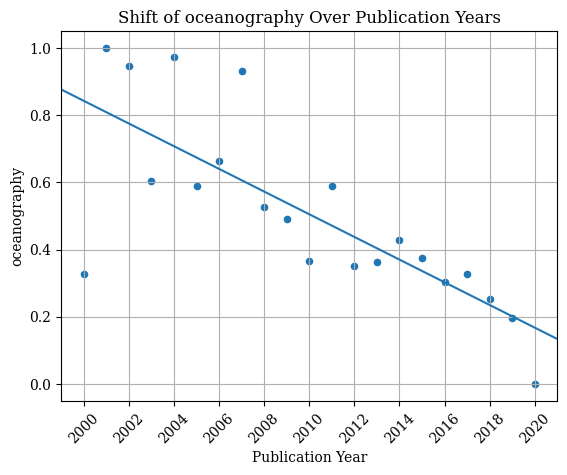

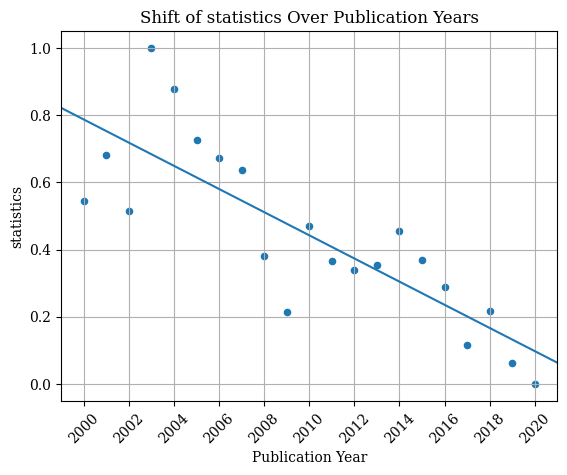

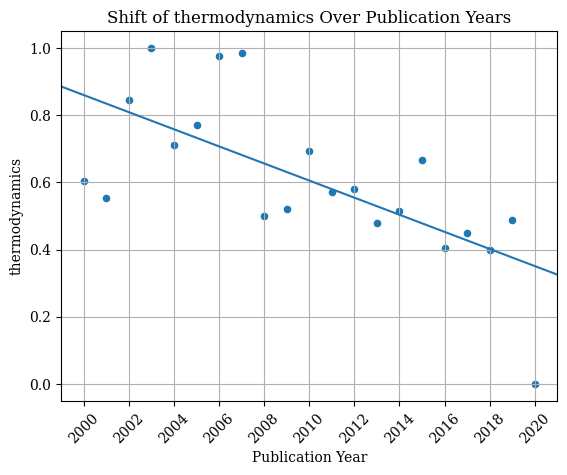

In [198]:
# all the cosine similarity regression results in one place
for i in cosim_df.columns[1:].to_list():
    ols_summary_plot(y=i, x='publication_year', df=cosim_df)